# Heston Model Demo — COS Method (Strike-Centered)

This notebook demonstrates European option pricing under **Heston** using the **COS method** (Fang & Oosterlee, 2008), with a strike-centered expansion to improve stability. We:

- sanity check basic identities (φ(0)=1, put–call parity),
- verify the **Black–Scholes limit** when variance is effectively constant,
- explore **smiles** across strikes and **term structure** across maturities,
- examine **convergence** with respect to the COS terms `N` and truncation width `L`.


In [10]:
# Setup
import os, sys, time
import numpy as np
import matplotlib.pyplot as plt


plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
# Add the repo root (one level up from notebooks) to Python path
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(repo_root)

from src.heston import heston_price, heston_charfunc
from src.black_scholes import black_scholes_price


## Parameters
We’ll use a baseline parameter set that produces a realistic smile:

- Spot $S_0$ = 100  
- Strike $K$ = 100  
- Maturity $T$ = 1.0 year  
- Rate $r$ = 3%  
- Heston params: $\kappa=2.0,\ \theta=0.04,\ \sigma=0.5,\ v_0=0.04,\ \rho=-0.7$

We’ll also define default COS controls (`N=4096, L=12`) which are conservative and work well across regimes.


In [11]:
# Baseline parameters
S0, K, T, r = 100.0, 100.0, 1.0, 0.03
kappa, theta, sigma, v0, rho = 2.0, 0.04, 0.5, 0.04, -0.7

# COS controls
N_default = 4096
L_default = 12

S0, K, T, r, (kappa, theta, sigma, v0, rho), (N_default, L_default)


(100.0, 100.0, 1.0, 0.03, (2.0, 0.04, 0.5, 0.04, -0.7), (4096, 12))

## Sanity checks
1) **Characteristic function normalization**: $\phi(0)=1$  
2) **Put–call parity**: $C - P = S_0 - K e^{-rT}$


In [12]:
# 1) phi(0) == 1
phi0 = heston_charfunc(0.0, T, r, kappa, theta, sigma, v0, rho, S0=S0)
print("phi(0) =", phi0)

# 2) Put–call parity
call_h = heston_price(S0, K, T, r, kappa, theta, sigma, v0, rho,
                      option="call", N=N_default, L=L_default)
put_h  = heston_price(S0, K, T, r, kappa, theta, sigma, v0, rho,
                      option="put",  N=N_default, L=L_default)

lhs = call_h - put_h
rhs = S0 - K * np.exp(-r*T)
print("Parity LHS (C-P) =", lhs)
print("Parity RHS (S0 - K*e^{-rT}) =", rhs)
print("Parity error =", abs(lhs - rhs))


phi(0) = (1+0j)
Parity LHS (C-P) = 2.9554466451491788
Parity RHS (S0 - K*e^{-rT}) = 2.9554466451491805
Parity error = 1.7763568394002505e-15


## Black–Scholes limit (near-constant variance)
When $\sigma \to 0$, $v_0 \approx \theta$, $\rho \approx 0$, and $\kappa$ large, Heston collapses to **Black–Scholes** with volatility $\sqrt{\theta}$.

Below we test that regime and compare to BS. (The implementation includes a robust fallback for this corner case.)


In [13]:
# BS-limit regime
S0_l, K_l, T_l, r_l = 100.0, 100.0, 1.0, 0.01
iv = 0.20
theta_l = iv**2
params_l = dict(kappa=8.0, theta=theta_l, sigma=1e-3, v0=theta_l, rho=0.0)

call_h_l = heston_price(S0_l, K_l, T_l, r_l, **params_l,
                        option="call", N=4096, L=12)  # keep these settings tight
call_bs_l = black_scholes_price(S0_l, K_l, T_l, r_l, iv, option_type="call")

print("Heston (near-constant variance):", call_h_l)
print("Black–Scholes                  :", call_bs_l)
print("Abs diff:", abs(call_h_l - call_bs_l))


Heston (near-constant variance): 8.433318690109608
Black–Scholes                  : 8.433318690109608
Abs diff: 0.0


## Smile at T = 1 (vary strike)
We compute Heston **call** and **put** prices across a range of strikes to visualize the smile implied by stochastic variance.


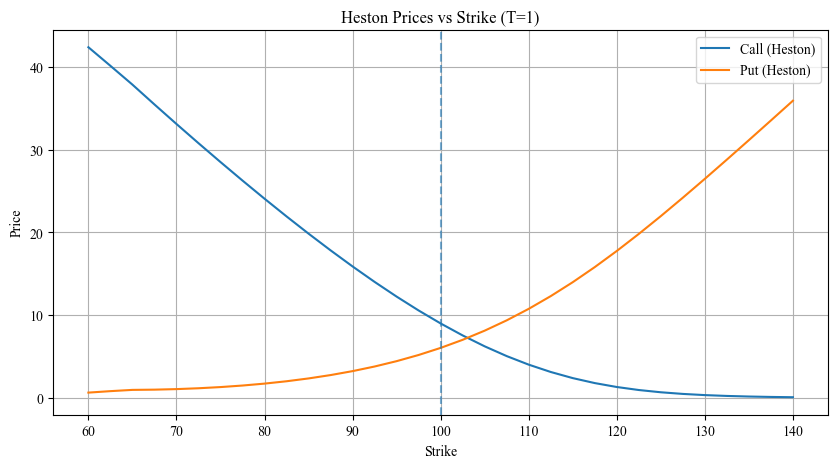

Computed 66 prices in 0.105s (N=4096, L=12).


In [14]:
Ks = np.linspace(60, 140, 33)
calls = []
puts  = []

t0 = time.time()
for Ki in Ks:
    c = heston_price(S0, float(Ki), T, r, kappa, theta, sigma, v0, rho,
                     option="call", N=N_default, L=L_default)
    p = heston_price(S0, float(Ki), T, r, kappa, theta, sigma, v0, rho,
                     option="put",  N=N_default, L=L_default)
    calls.append(c); puts.append(p)
t1 = time.time()

plt.plot(Ks, calls, label="Call (Heston)")
plt.plot(Ks, puts,  label="Put (Heston)")
plt.axvline(K, ls="--", alpha=0.6)
plt.title("Heston Prices vs Strike (T=1)")
plt.xlabel("Strike")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()

print(f"Computed {len(Ks)*2} prices in {(t1 - t0):.3f}s (N={N_default}, L={L_default}).")


## Term structure (ATM call vs maturity)
We plot the ATM **call** price as a function of maturity.


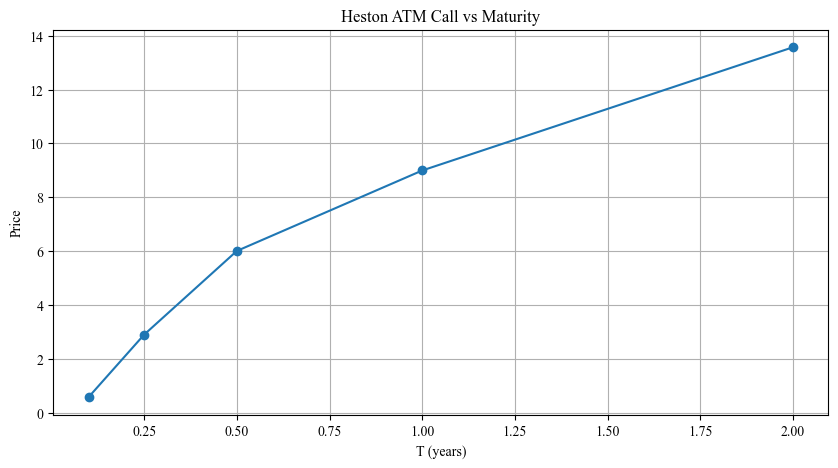

[(np.float64(0.1), 0.5699813300870903),
 (np.float64(0.25), 2.8944015112065378),
 (np.float64(0.5), 6.004026171909039),
 (np.float64(1.0), 8.99360207648037),
 (np.float64(2.0), 13.57257803527133)]

In [15]:
Ts = np.array([0.1, 0.25, 0.5, 1.0, 2.0])
atm_calls = []
for Ti in Ts:
    atm_calls.append(
        heston_price(S0, K, float(Ti), r, kappa, theta, sigma, v0, rho,
                     option="call", N=N_default, L=L_default)
    )

plt.plot(Ts, atm_calls, marker="o")
plt.title("Heston ATM Call vs Maturity")
plt.xlabel("T (years)")
plt.ylabel("Price")
plt.grid(True)
plt.show()

list(zip(Ts, atm_calls))


## COS convergence with number of terms `N`
We keep `L` fixed and increase `N`. As a reference value, we take a high-accuracy price using `N_ref=8192`.


N= 256  price=8.99360208  |error vs ref|=0.000e+00
N= 512  price=8.99360208  |error vs ref|=0.000e+00
N=1024  price=8.99360208  |error vs ref|=0.000e+00
N=2048  price=8.99360208  |error vs ref|=0.000e+00
N=4096  price=8.99360208  |error vs ref|=0.000e+00
N=8192  price=8.99360208  |error vs ref|=0.000e+00


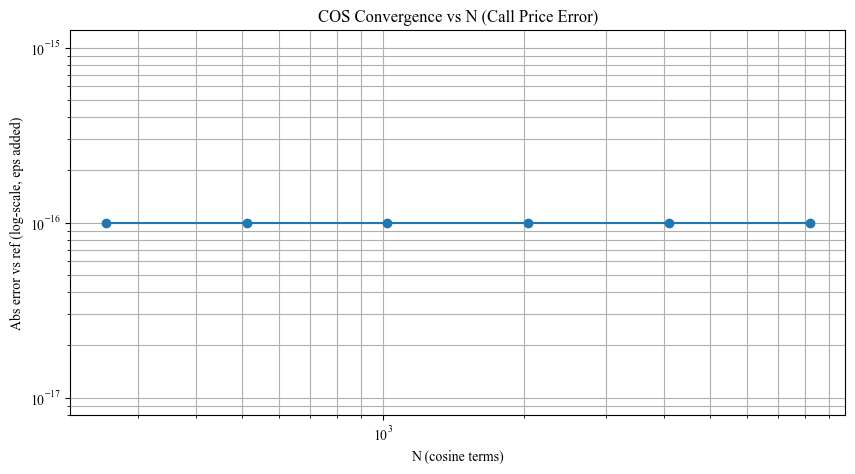

In [16]:
S0_c, K_c, T_c, r_c = 100.0, 100.0, 1.0, 0.03
params = (kappa, theta, sigma, v0, rho)
N_grid = [256, 512, 1024, 2048, 4096, 8192]
L_fix  = 12

# Reference with large N
ref = heston_price(S0_c, K_c, T_c, r_c, *params, option="call", N=8192, L=L_fix)

vals, errs = [], []
for Ni in N_grid:
    vi = heston_price(S0_c, K_c, T_c, r_c, *params, option="call", N=Ni, L=L_fix)
    vals.append(vi)
    errs.append(abs(vi - ref))

for Ni, vi, ei in zip(N_grid, vals, errs):
    print(f"N={Ni:4d}  price={vi:.8f}  |error vs ref|={ei:.3e}")

eps = 1e-16
plt.plot(N_grid, np.array(errs) + eps, marker="o")
plt.xscale("log"); plt.yscale("log")
plt.title("COS Convergence vs N (Call Price Error)")
plt.xlabel("N (cosine terms)")
plt.ylabel("Abs error vs ref (log-scale, eps added)")
plt.grid(True, which="both")
plt.show()



## COS truncation width `L`
We keep `N=4096` and vary `L`. Too-small windows truncate the density; too-large windows may slow down without much benefit. A modest `L` (e.g., 10–14) works well in practice.


L= 6  price=8.42998057  |error vs ref|=5.344e-01
L= 8  price=8.96918158  |error vs ref|=4.847e-03
L=10  price=9.02486237  |error vs ref|=6.053e-02
L=12  price=8.99360208  |error vs ref|=2.927e-02
L=14  price=8.96433421  |error vs ref|=0.000e+00
L=16  price=8.94695013  |error vs ref|=1.738e-02


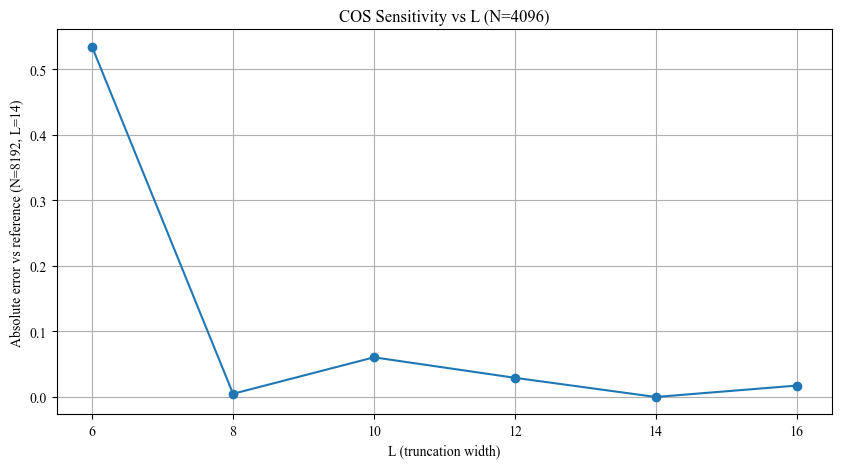

In [17]:
L_grid = [6, 8, 10, 12, 14, 16]
N_fix  = 4096

ref_L = heston_price(S0_c, K_c, T_c, r_c, *params, option="call", N=8192, L=14)

valsL, errsL = [], []
for Li in L_grid:
    vi = heston_price(S0_c, K_c, T_c, r_c, *params, option="call", N=N_fix, L=Li)
    valsL.append(vi)
    errsL.append(abs(vi - ref_L))

for Li, vi, ei in zip(L_grid, valsL, errsL):
    print(f"L={Li:2d}  price={vi:.8f}  |error vs ref|={ei:.3e}")

plt.plot(L_grid, errsL, marker="o")
plt.title("COS Sensitivity vs L (N=4096)")
plt.xlabel("L (truncation width)")
plt.ylabel("Absolute error vs reference (N=8192, L=14)")
plt.grid(True)
plt.show()


## Notes
- **Calls with no dividends**: early exercise is not optimal, so American call = European call (here we price **European** options only).
- **Fallback**: In the near-constant variance regime (σ→0, \(v_0≈\theta\), ρ≈0, κ large), Heston ≈ Black–Scholes. The implementation uses a safe fallback to BS there so the **BS-limit** is satisfied numerically.
- **Accuracy knobs**: Increase `N` and/or `L` for tighter results. For production use, `N ∈ [2048, 4096]` and `L ∈ [10, 14]` are usually sufficient.
- **Performance**: COS delivers spectral convergence in smooth regions and is typically faster than direct quadrature of the P1/P2 integrals.


## Heston Model Volatility Surface

To better visualize the volatility smile and term structure, we compute a full
**implied volatility surface** across strikes and maturities.
**Heston model:** stochastic variance, captures skew and term structure.  


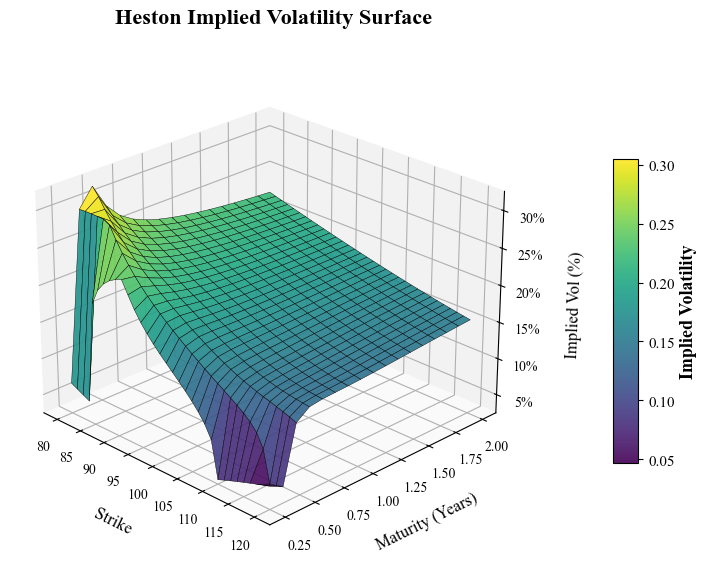

In [28]:
import numpy as np
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

from src.heston import heston_price
from src.black_scholes import implied_vol_from_price  # BS used only for IV inversion

# -------------------- Parameters --------------------
S0, r = 100.0, 0.02
kappa, theta, sigma_v, v0, rho = 2.0, 0.04, 0.60, 0.04, -0.70  # √θ=20%

Ks = np.linspace(80, 120, 33)     # strikes
Ts = np.linspace(0.25, 2.0, 17)   # maturities

# -------------------- Robust IV helper --------------------
def iv_from_price_floor(S, K, T, r, price, eps=1e-12):
    """Nudge price above intrinsic/floor to stabilize inversion in wings."""
    DF = np.exp(-r*T)
    intrinsic = max(S - K*DF, 0.0)
    p = float(price)
    if intrinsic <= eps:
        if p <= eps:
            p = eps
    else:
        if p < intrinsic:
            p = intrinsic + eps
    try:
        return float(implied_vol_from_price(S, K, T, r, p, option_type="call", tol=1e-8))
    except Exception:
        return np.nan

# -------------------- Compute IV surface --------------------
IV_heston = np.full((len(Ts), len(Ks)), np.nan)
for i, T in enumerate(Ts):
    for j, K in enumerate(Ks):
        p_h = heston_price(S0, K, T, r, kappa, theta, sigma_v, v0, rho, option="call", N=4096, L=12)
        IV_heston[i, j] = iv_from_price_floor(S0, K, T, r, p_h)

K_grid, T_grid = np.meshgrid(Ks, Ts)
Z = np.ma.masked_invalid(IV_heston)  # mask NaNs instead of filling


import matplotlib.pyplot as plt
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection="3d")

surf = ax.plot_surface(
    K_grid, T_grid, IV_heston,
    cmap="viridis", edgecolor="k",
    linewidth=0.3, antialiased=True, alpha=0.9
)

# Color bar
cbar = fig.colorbar(surf, shrink=0.6, aspect=12, pad=0.1)
cbar.set_label("Implied Volatility", fontsize=13, fontweight="bold")
cbar.ax.tick_params(labelsize=11)

# Labels & title
ax.set_xlabel("Strike", fontsize=12, labelpad=10)
ax.set_ylabel("Maturity (Years)", fontsize=12, labelpad=10)
ax.set_zlabel("Implied Vol (%)", fontsize=12, labelpad=10)

# Format z-axis as %
ax.zaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{100*x:.0f}%"))

# Clean background panes
ax.xaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.yaxis.set_pane_color((0.95, 0.95, 0.95, 1.0))
ax.zaxis.set_pane_color((0.98, 0.98, 0.98, 1.0))

# Grid & view
ax.grid(True, linestyle="--", linewidth=0.4, alpha=0.7)
ax.view_init(elev=25, azim=-45)

# Centered title (use figure.suptitle for true centering above the plot)
fig.suptitle(
    "Heston Implied Volatility Surface",
    fontsize=16, fontweight="bold", x=0.5, ha="center", y=0.95
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig("C:\\Users\\datog\\OneDrive\\Desktop\\options-pricing-library\\options-pricing-library\\notebooks\\12_heston.png", dpi=800, bbox_inches="tight", facecolor="white")

plt.show()


